# The Community-Aware Node Features for GNN
*GNN in PyTorch with new features*

By: Sebastian Zajac<br>
Date: september 2024<br>
Aims: The goal of this notebook is to build a GNN networks for graphs data with add new features based on community structure
    to graphs node features.
Methods:  

Sources: 
1. Hand-On Graph Neural Netowrks Usin Python , M. Labonne,
2. Deep Learning with PyTorch, second edition. L. Antiga, E Stevens, H. Huang, T. Viechmann

Notes:
- there is no node features for ABCD+o graph
- new node features
- embeddings Node2Vec and Struc2Vec

## Load data to PyTorch dataset

1. ABCD+o
- graph edges must be change to edges_index, with is just transposition of edges list.
- new nodes features
- embeddings

2. Edges list is start from 1 - like in Julia. Remember about changint it to start from 0. 

In [4]:
import torch
import pyarrow.parquet as pq
import numpy as np

from torch_geometric.data import Data

from utils import visualize
from myNN import MLP

In [15]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = "cpu"

In [16]:
DATA_PATH = "../data/"
X3_GRAPH = "edge_x3.parquet"
FEATURES = "x3.parquet"

In [17]:
edges_tab = pq.read_table(f'{DATA_PATH}{X3_GRAPH}')
features_tab = pq.read_table(f'{DATA_PATH}{FEATURES}')

# to pandas
df_x3_edges = edges_tab.to_pandas()
df_x3 = features_tab.to_pandas()

In [18]:
# nodes index start from 0
df_x3_edges = df_x3_edges.apply(lambda x: x-1, axis=1)
# target column
df_x3_y = df_x3['target'].astype(np.int32)
# features 
df_x3 = df_x3.drop(columns=['target','node_id']).astype(np.float32)

In [19]:
df_x3.head(3), df_x3_edges.head(3)

(   participation  in_mod_deg  beta_star  edge_contr      cada        kl  \
 0       0.072612    5.115763   0.071551    0.161943  6.175000  0.081967   
 1       0.554606   14.985703   0.648982    0.740343  1.350725  1.288886   
 2       0.534563   19.956850   0.590207    0.726829  1.375839  0.928937   
 
          l1        l2        hd       kl2  ...       l22       hd2       lcc  \
 0  0.258551  0.100798  0.150758  0.059234  ...  0.070834  0.123505  0.009354   
 1  1.302687  0.669719  0.538414  0.395120  ...  0.319003  0.294885  0.014915   
 2  1.167858  0.598765  0.481112  0.353271  ...  0.337305  0.287217  0.012368   
 
          bc     dc        ndc        cc        ec  eccen  core  
 0  0.078458  494.0  38.518219  0.458186  0.199689    4.0  12.0  
 1  0.039203  466.0  28.474249  0.416226  0.199501    4.0  12.0  
 2  0.038083  410.0  27.126829  0.405902  0.108520    4.0  12.0  
 
 [3 rows x 21 columns],
    in  out
 0   0    1
 1   0    4
 2   0    5)

Prepering elements of torch graph dataset elements 
- x (features)
- y  (target)
- edge_index (graph structure)

In [20]:
# x = torch.from_numpy(np.array(df_x3)).to(device)
x = torch.from_numpy(np.array(df_x3[['cada','beta_star']])).to(device)
y = torch.from_numpy(np.array(df_x3_y)).type(torch.LongTensor).to(device)
edge_list = torch.from_numpy(df_x3_edges[["in","out"]].to_numpy()).to(device)

data = Data(x=x, edge_index=edge_list.T.to(device), y=y).to(device)

In [21]:
data
print(f'Number of features: {data.num_features}')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')

Number of features: 2
Number of nodes: 10000
Number of edges: 61421


In [22]:
data.train_mask = range(7000)
data.val_mask = range(7001, 9000)
data.test_mask = range(9001, 10000)

In [23]:
mlp = MLP(data.num_features, 16, 2).to(device)
print(mlp)
mlp.fit(data, epochs=100)
acc = mlp.test(data)
print(f'MLP test accuracy: {acc*100:.2f}%')

MLP(
  (linear1): Linear(in_features=2, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=2, bias=True)
)
Epoch   0 | Train Loss: 1.002 | Train Acc: 10.00% | Val Loss 1.01 | Val Acc: 9.95% 
Epoch  20 | Train Loss: 0.216 | Train Acc: 90.00% | Val Loss 0.24 | Val Acc: 90.05% 
Epoch  40 | Train Loss: 0.105 | Train Acc: 96.29% | Val Loss 0.16 | Val Acc: 93.45% 
Epoch  60 | Train Loss: 0.046 | Train Acc: 98.73% | Val Loss 0.10 | Val Acc: 97.40% 
Epoch  80 | Train Loss: 0.024 | Train Acc: 99.26% | Val Loss 0.08 | Val Acc: 97.90% 
Epoch 100 | Train Loss: 0.018 | Train Acc: 99.60% | Val Loss 0.08 | Val Acc: 98.15% 
MLP test accuracy: 99.10%


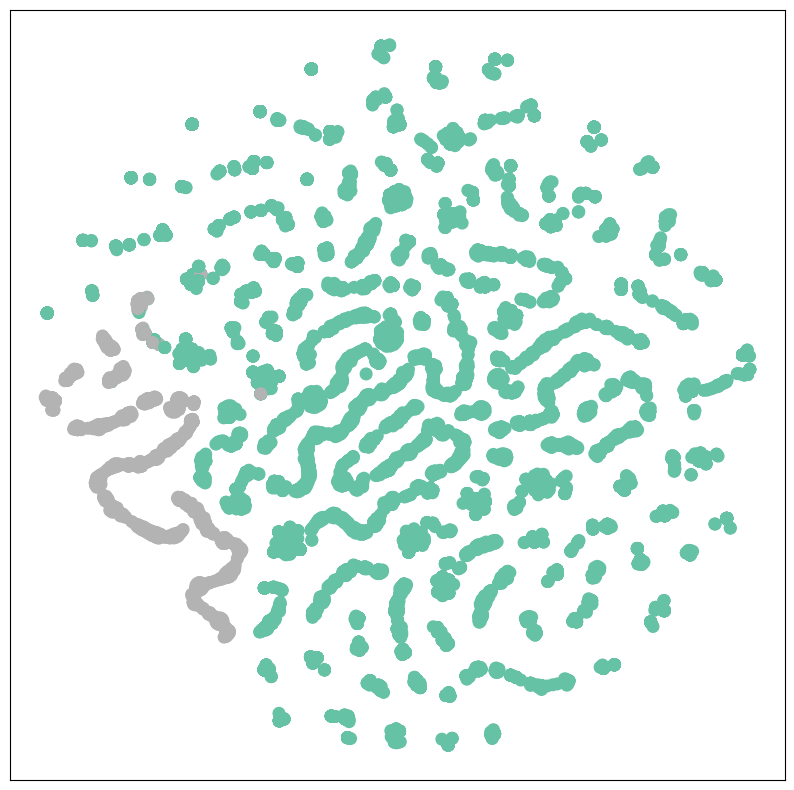

In [24]:
mlp.eval()
out = mlp(data.x)
visualize(out, color=data.y)